<a href="https://colab.research.google.com/github/BoyoungH/2D-to-3D-Nerf/blob/main/tiny_nerf_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/aliutkus/torchsearchsorted
import torchsearchsorted

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aliutkus/torchsearchsorted to /tmp/pip-req-build-pvtuv4ox
  Running command git clone --filter=blob:none --quiet https://github.com/aliutkus/torchsearchsorted /tmp/pip-req-build-pvtuv4ox
  Resolved https://github.com/aliutkus/torchsearchsorted to commit 22b628aa348abb854aef8660fed67d98b7676fc9
  Preparing metadata (setup.py) ... done
  Created wheel for torchsearchsorted: filename=torchsearchsorted-1.1-cp310-cp310-linux_x86_64.whl size=6547191 sha256=5674748a4b5c9e1fc57fff7fedb150235cf2e3228d51429a5b0f21d1176ffdef
  Stored in directory: /tmp/pip-ephem-wheel-cache-8n1_yra4/wheels/66/03/bf/287777e30536367f12403b7ecbb6eb92dc5045053c9132cece
Successfully built torchsearchsorted


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch import nn, optim


def get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os):
    u_is_c = torch.rand(*list(ds.shape[:2]) + [N_c]).to(ds)
    t_is_c = t_i_c_bin_edges + u_is_c * t_i_c_gap
    r_ts_c = os[..., None, :] + t_is_c[..., :, None] * ds[..., None, :]
    return (r_ts_c, t_is_c)


def get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds, r_ts_c, N_d, d_std, t_n):
    w_is_c = w_is_c + 1e-5
    pdfs = w_is_c / torch.sum(w_is_c, dim=-1, keepdim=True)
    cdfs = torch.cumsum(pdfs, dim=-1)
    cdfs = torch.cat([torch.zeros_like(cdfs[..., :1]), cdfs[..., :-1]], dim=-1)

    us = torch.rand(list(cdfs.shape[:-1]) + [N_f]).to(w_is_c)

    idxs = torch.searchsorted(cdfs, us, right=True)
    t_i_f_bottom_edges = torch.gather(t_is_c, 2, idxs - 1)
    idxs_capped = idxs.clone()
    max_ind = cdfs.shape[-1]
    idxs_capped[idxs_capped == max_ind] = max_ind - 1
    t_i_f_top_edges = torch.gather(t_is_c, 2, idxs_capped)
    t_i_f_top_edges[idxs == max_ind] = t_f
    t_i_f_gaps = t_i_f_top_edges - t_i_f_bottom_edges
    u_is_f = torch.rand_like(t_i_f_gaps).to(os)
    t_is_f = t_i_f_bottom_edges + u_is_f * t_i_f_gaps

    # See Section B.1 in the Supplementary Materials and:
    # https://github.com/sxyu/pixel-nerf/blob/a5a514224272a91e3ec590f215567032e1f1c260/src/render/nerf.py#L150.
    t_is_d = (w_is_c * r_ts_c[..., 2]).sum(dim=-1)
    t_is_d = t_is_d.unsqueeze(2).repeat((1, 1, N_d))
    t_is_d = t_is_d + torch.normal(0, d_std, size=t_is_d.shape).to(t_is_d)
    t_is_d = torch.clamp(t_is_d, t_n, t_f)

    t_is_f = torch.cat([t_is_c, t_is_f.detach(), t_is_d], dim=-1)
    (t_is_f, _) = torch.sort(t_is_f, dim=-1)
    r_ts_f = os[..., None, :] + t_is_f[..., :, None] * ds[..., None, :]

    return (r_ts_f, t_is_f)

def get_image_features_for_query_points(r_ts, camera_distance, scale, W_i):
    pi_x_is = r_ts[..., :2] / (camera_distance - r_ts[..., 2].unsqueeze(-1))
    pi_x_is = pi_x_is / scale
    pi_x_is[..., 1] = -1 * pi_x_is[..., 1]
    pi_x_is = pi_x_is.permute(2, 0, 1, 3)
    W_i = W_i.repeat(pi_x_is.shape[0], 1, 1, 1)
    z_is = nn.functional.grid_sample(W_i, pi_x_is, align_corners=True, padding_mode="border")
    z_is = z_is.permute(2, 3, 0, 1)
    return z_is


def render_radiance_volume(r_ts, ds, z_is, chunk_size, F, t_is):
    r_ts_flat = r_ts.reshape((-1, 3))
    ds_rep = ds.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
    ds_flat = ds_rep.reshape((-1, 3))
    z_is_flat = z_is.reshape((ds_flat.shape[0], -1))
    c_is = []
    sigma_is = []
    for chunk_start in range(0, r_ts_flat.shape[0], chunk_size):
        r_ts_batch = r_ts_flat[chunk_start : chunk_start + chunk_size]
        ds_batch = ds_flat[chunk_start : chunk_start + chunk_size]
        w_is_batch = z_is_flat[chunk_start : chunk_start + chunk_size]
        preds = F(r_ts_batch, ds_batch, w_is_batch)
        c_is.append(preds["c_is"])
        sigma_is.append(preds["sigma_is"])

    c_is = torch.cat(c_is)
    c_is = torch.reshape(c_is, r_ts.shape)
    sigma_is = torch.cat(sigma_is)
    sigma_is = torch.reshape(sigma_is, r_ts.shape[:-1])

    delta_is = t_is[..., 1:] - t_is[..., :-1]
    one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
    delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
    delta_is = delta_is * ds.norm(dim=-1).unsqueeze(-1)

    alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)

    T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0

    w_is = T_is * alpha_is

    C_rs = (w_is[..., None] * c_is).sum(dim=-2)

    return (C_rs, w_is)


def run_one_iter_of_nerf(
    ds,
    N_c,
    t_i_c_bin_edges,
    t_i_c_gap,
    os,
    camera_distance,
    scale,
    W_i,
    chunk_size,
    F_c,
    N_f,
    t_f,
    N_d,
    d_std,
    t_n,
    F_f,
):
    (r_ts_c, t_is_c) = get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os)
    z_is_c = get_image_features_for_query_points(r_ts_c, camera_distance, scale,  W_i)
    (C_rs_c, w_is_c) = render_radiance_volume(
        r_ts_c, ds, z_is_c, chunk_size, F_c, t_is_c
    )

    (r_ts_f, t_is_f) = get_fine_query_points(
        w_is_c, N_f, t_is_c, t_f, os, ds, r_ts_c, N_d, d_std, t_n
    )
    z_is_f = get_image_features_for_query_points(r_ts_f, camera_distance, scale, W_i)
    (C_rs_f, _) = render_radiance_volume(r_ts_f, ds, z_is_f, chunk_size, F_f, t_is_f)
    return (C_rs_c, C_rs_f)


class NeRFMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.L_pos = 6
        self.L_dir = 0
        pos_enc_feats = 3 + 3 * 2 * self.L_pos
        dir_enc_feats = 3 + 3 * 2 * self.L_dir
        # Set up ResNet MLP.
        net_width = 512
        self.first_layer = nn.Sequential(
            nn.Linear(pos_enc_feats + dir_enc_feats, net_width)
        )
        self.n_resnet_blocks = 5
        z_linears = []
        mlps = []
        for resnet_block in range(self.n_resnet_blocks):
            z_linears.append(nn.Linear(net_width, net_width))
            mlps.append(
                nn.Sequential(
                    nn.Linear(net_width, net_width),
                    nn.ReLU(),
                    nn.Linear(net_width, net_width),
                    nn.ReLU(),
                )
            )

        self.z_linears = nn.ModuleList(z_linears)
        self.mlps = nn.ModuleList(mlps)
        self.final_layer = nn.Linear(net_width, 4)

    def forward(self, xs, ds, zs):
        xs_encoded = [xs]
        for l_pos in range(self.L_pos):
            xs_encoded.append(torch.sin(2 ** l_pos * torch.pi * xs))
            xs_encoded.append(torch.cos(2 ** l_pos * torch.pi * xs))

        xs_encoded = torch.cat(xs_encoded, dim=-1)

        ds = ds / ds.norm(p=2, dim=-1).unsqueeze(-1)
        ds_encoded = [ds]
        for l_dir in range(self.L_dir):
            ds_encoded.append(torch.sin(2 ** l_dir * torch.pi * ds))
            ds_encoded.append(torch.cos(2 ** l_dir * torch.pi * ds))

        ds_encoded = torch.cat(ds_encoded, dim=-1)

        outputs = self.first_layer(torch.cat([xs_encoded, ds_encoded], dim=-1))
        for block_idx in range(self.n_resnet_blocks):
            resnet_zs = self.z_linears[block_idx](zs)
            outputs = outputs + resnet_zs
            outputs = self.mlps[block_idx](outputs) + outputs

        outputs = self.final_layer(outputs)
        sigma_is = torch.relu(outputs[:, 0])
        c_is = torch.sigmoid(outputs[:, 1:])
        return {"c_is": c_is, "sigma_is": sigma_is}



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet34
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet34(True)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        feats1 = self.resnet.relu(x)

        feats2 = self.resnet.layer1(self.resnet.maxpool(feats1))
        feats3 = self.resnet.layer2(feats2)
        feats4 = self.resnet.layer3(feats3)

        latents = [feats1, feats2, feats3, feats4]
        latent_sz = latents[0].shape[-2:]
        for i in range(len(latents)):
            latents[i] = F.interpolate(
                latents[i], latent_sz, mode="bilinear", align_corners=True
            )

        latents = torch.cat(latents, dim=1)
        return latents

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 270MB/s]


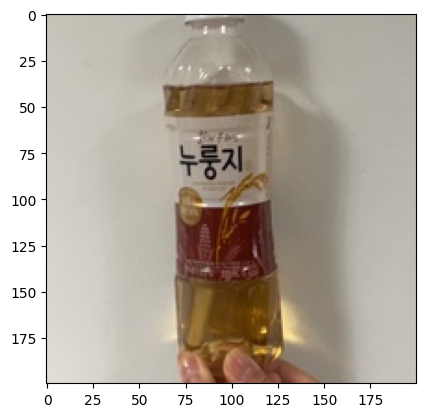

ImageEncoder(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# Set seed.
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

device = "cuda:0"
F_c = NeRFMLP().to(device)
F_f = NeRFMLP().to(device)
E = ImageEncoder().to(device)
chunk_size = 1024 * 32
batch_img_size = 12 #64
n_batch_pix = batch_img_size ** 2

lr = 1e-4 #5e-4
optimizer = optim.Adam(list(F_c.parameters()) + list(F_f.parameters()), lr=lr)
criterion = nn.MSELoss()
#lrate_decay = 250
#decay_steps = lrate_decay * 1000
#decay_rate = 0.1
# Load dataset.
data_f = "/content/drive/MyDrive/nooo.npz"
data = np.load(data_f)

images = data["normalized_array"] #spongee->rgb
img_size = images.shape[1]
xs = torch.arange(img_size) - (img_size / 2 - 0.5)
ys = torch.arange(img_size) - (img_size / 2 - 0.5)
(xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")
focal = float(data["focal"])
pixel_coords = torch.stack([xs, ys, torch.full_like(xs, -focal)], dim=-1)
camera_coords = pixel_coords / focal
init_ds = camera_coords.to(device)
init_o = torch.Tensor(np.array([0, 0, 2.25])).to(device)

test_idx = 0
plt.imshow(images[test_idx])
plt.show()
test_img = torch.Tensor(images[test_idx]).to(device)

source_img=images[test_idx]

poses = data["poses"]
test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
test_os = (test_R @ init_o).expand(test_ds.shape)

camera_distance=2.25
scale = (img_size / 2) / focal

t_n = 1.0
t_f = 4.0
N_c = 64
N_f = 16#128
N_d = 16
d_std = 0.01
t_i_c_gap = (t_f - t_n) / N_c
t_i_c_bin_edges = (t_n + torch.arange(N_c) * t_i_c_gap).to(device)

# Start training model.
train_idxs = np.arange(len(images)) != test_idx
images = torch.Tensor(images[train_idxs])
poses = torch.Tensor(poses[train_idxs])
n_pix = img_size ** 2
pixel_ps = torch.full((n_pix,), 1 / n_pix).to(device)
psnrs = []
iternums = []
# See Section 5.3.
num_iters = 300000
display_every = 100
F_c.train()
F_f.train()
E.eval()

In [ ]:
source_image = torch.Tensor(test_img)
channel_means = torch.Tensor([0.485, 0.456, 0.406]).to(device)
channel_stds = torch.Tensor([0.229, 0.224, 0.225]).to(device)
source_image = (source_image - channel_means) / channel_stds
source_image = source_image.to(device).unsqueeze(0).permute(0, 3, 1, 2)
for i in range(num_iters):
    target_img_idx = np.random.randint(images.shape[0])
    target_pose = poses[target_img_idx].to(device)
    R = target_pose[:3, :3]
    loss = 0

    ds = torch.einsum("ij,hwj->hwi", R, init_ds)
    os = (R @ init_o).expand(ds.shape)

    pix_idxs = pixel_ps.multinomial(n_batch_pix, False)
    pix_idx_rows = pix_idxs // img_size
    pix_idx_cols = pix_idxs % img_size
    ds_batch = ds[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )
    os_batch = os[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )

    with torch.no_grad():
        W_i = E(test_img.unsqueeze(0).permute(0, 3, 1, 2).to(device))

    # Run NeRF.
    (C_rs_c, C_rs_f) = run_one_iter_of_nerf(
        ds_batch,
        N_c,
        t_i_c_bin_edges,
        t_i_c_gap,
        os_batch,
        camera_distance,
        scale,
        W_i,
        chunk_size,
        F_c,
        N_f,
        t_f,
        N_d,
        d_std,
        t_n,
        F_f,
    )
    target_img = images[target_img_idx].to(device)
    target_img_batch = target_img[pix_idx_rows, pix_idx_cols].reshape(C_rs_f.shape)
    #loss = criterion(C_rs_c, target_img_batch) + criterion(C_rs_f, target_img_batch)
    loss += criterion(C_rs_c, target_img_batch)
    loss += criterion(C_rs_f, target_img_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #for g in optimizer.param_groups:
    #    g["lr"] = lr * decay_rate ** (i / decay_steps)

    if i % display_every == 0:
        F_c.eval()
        F_f.eval()
        with torch.no_grad():
            test_W_i = E(source_image)
            (_, C_rs_f) = run_one_iter_of_nerf(
                test_ds,
                N_c,
                t_i_c_bin_edges,
                t_i_c_gap,
                test_os,
                camera_distance,
                scale,
                test_W_i,
                #W_i,
                chunk_size,
                F_c,
                N_f,
                t_f,
                N_d,
                d_std,
                t_n,
                F_f,
            )

        loss = criterion(C_rs_f, test_img)
        print(f"Loss: {loss.item()}")
        psnr = -10.0 * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(C_rs_f.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

        F_c.train()
        F_f.train()

print("Done!")

OutOfMemoryError: ignored

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets
import numpy as np
import torch
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode
from torch.autograd import grad
import torch.nn.functional as nnF

# checkpoint = torch.load('/content/nerf_model.pth')
# F_c.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# iteration = checkpoint['iteration']
# loss = checkpoint['loss']
# psnrs = checkpoint['psnrs']
# iternums = checkpoint['iternums']
# C_rs_c = checkpoint['C_rs_c']
# C_rs_f = checkpoint['C_rs_f']


def trans_t(t):
  return torch.tensor([
  [1,0,0,0],
  [0,1,0,0],
  [0,0,1,t],
  [0,0,0,1],
  ], dtype=torch.float32)

def rot_phi(phi):
    phi = torch.tensor(phi)
    return torch.tensor([
        [1, 0, 0, 0],
        [0, torch.cos(phi), -torch.sin(phi), 0],
        [0, torch.sin(phi), torch.cos(phi), 0],
        [0, 0, 0, 1],
    ], dtype=torch.float32)

def rot_theta(th):
    th = torch.tensor(th)
    return torch.tensor([
        [torch.cos(th), 0, -torch.sin(th), 0],
        [0, 1, 0, 0],
        [torch.sin(th), 0, torch.cos(th), 0],
        [0, 0, 0, 1],
    ], dtype=torch.float32)

def pose_spherical(theta, phi, radius):
  c2w = trans_t(radius)
  c2w = rot_phi(phi/180.*np.pi) @ c2w
  c2w = rot_theta(theta/180.*np.pi) @ c2w
  c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]], dtype=torch.float32) @ c2w
  return c2w

def f(**kwargs):
  c2w = pose_spherical(**kwargs)
  c2w = c2w.to(device)
  test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
  test_R = c2w[:3, :3].to(device)
  test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
  test_os = (test_R @ init_o).expand(test_ds.shape)
  with torch.no_grad():
            (_, C_rs_f) = run_one_iter_of_nerf(
                test_ds,
                N_c,
                t_i_c_bin_edges,
                t_i_c_gap,
                test_os,
                chunk_size,
                F_c,
                N_f,
                t_f,
                F_f,
                N_d,
                d_std,
            )
  img = torch.clamp((C_rs_f.detach()), 0, 1)
  img = img.permute(2, 0, 1)

  img_np = img.cpu().numpy()
  plt.figure(2, figsize=(20,6))
  plt.imshow(img_np.transpose(1, 2, 0))
  plt.show()

sldr = lambda v, mi, ma: widgets.FloatSlider(
  value=v,
  min=mi,
  max=ma,
  step=.01,
)

names = [
  ['theta', [100., 0., 360]],
  ['phi', [-30., 0, 360]],
  ['radius', [4., 3., 5.]],
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=0…

In [ ]:
frames = []
from tqdm import tqdm_notebook as tqdm
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
    test_R = c2w[:3, :3].to(device)
    test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
    test_os = (test_R @ init_o).expand(test_ds.shape)
    with torch.no_grad():
            (_, C_rs_f) = run_one_iter_of_nerf(
                test_ds,
                N_c,
                t_i_c_bin_edges,
                t_i_c_gap,
                test_os,
                chunk_size,
                F_c,
                N_f,
                t_f,
                F_f,
                N_d,
                d_std,
            )
    frames.append((C_rs_f.detach().cpu().numpy()).astype(np.uint8))

import cv2

frames_resized = []
for frame in frames:
    frame_resized = cv2.resize(frame, (304, 304))
    frames_resized.append(frame_resized)

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames_resized, fps=30, quality=7)

<ipython-input-8-a06c6cfa0d1f>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)